Fourier series expand for Solving Wall Heat Transfer

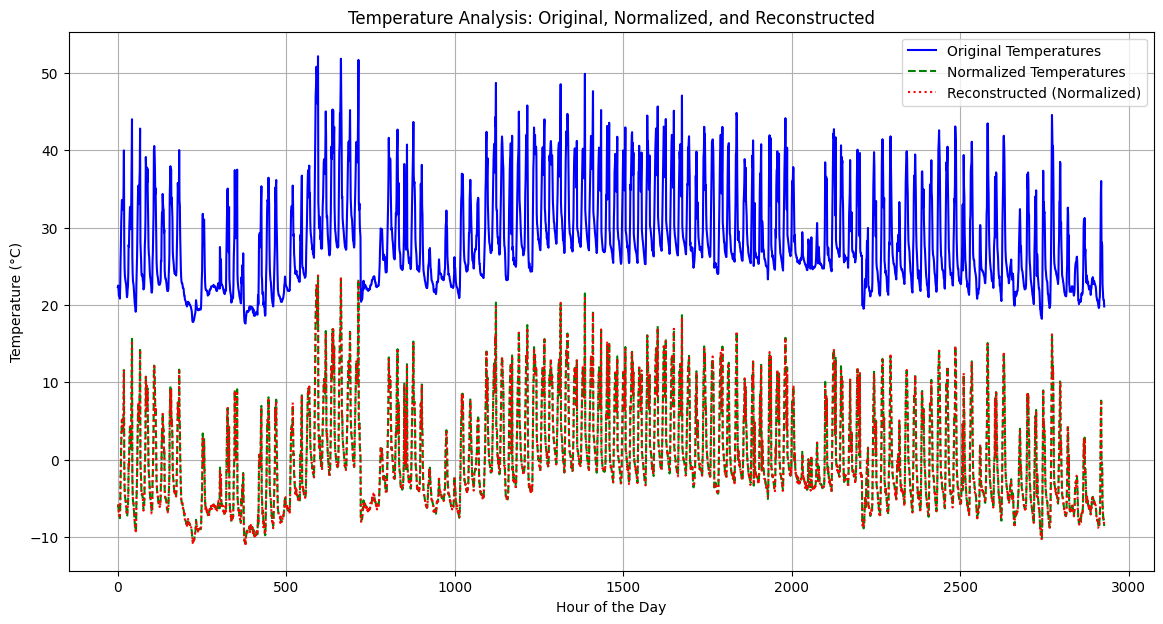

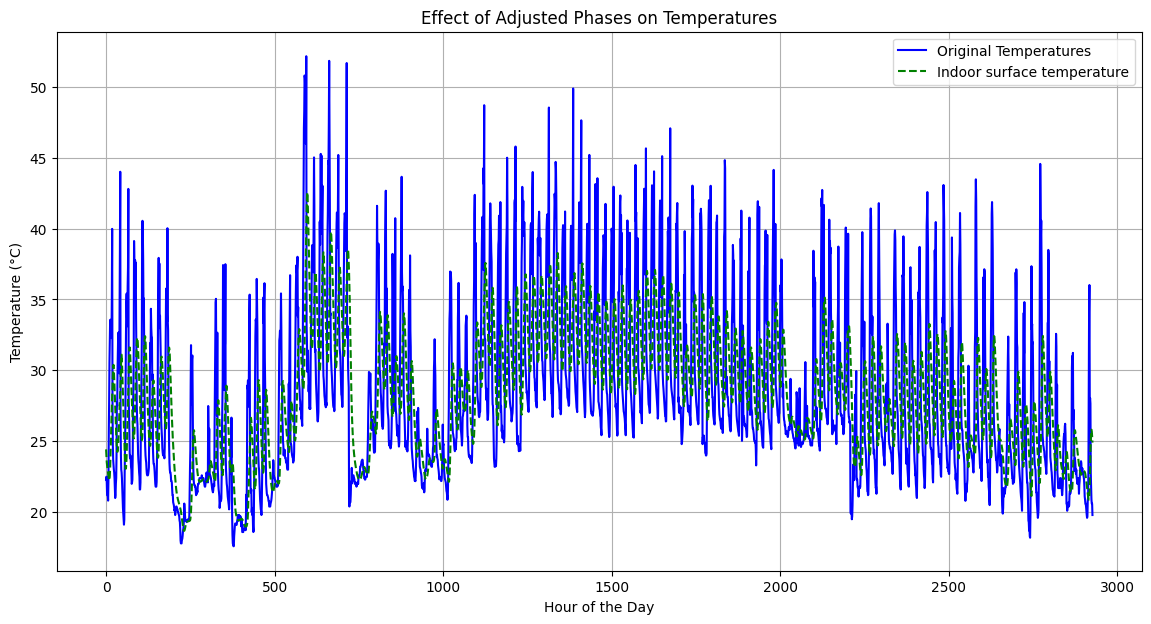

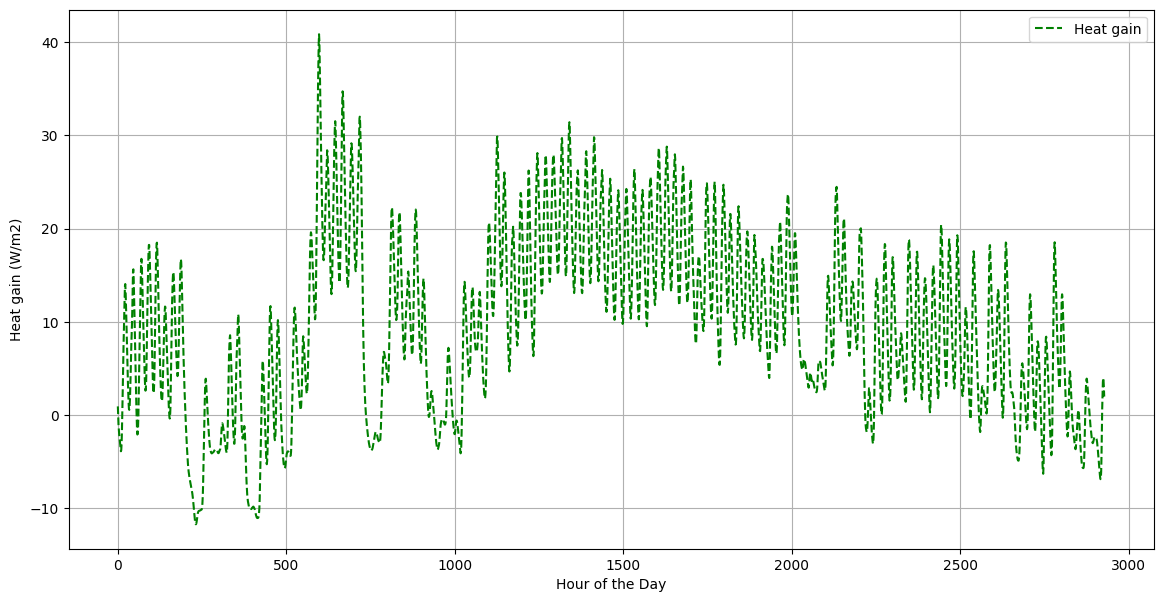

In [1]:
import pandas as pd
import numpy as np
import torch
from sympy import symbols, sympify
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import *  
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Read data from the Excel file
df = pd.read_excel('test_data.xlsx')

# Extract the Outdoor_temp column and convert it to a NumPy array
temperatures = df['Outdoor_temp'].to_numpy()

# Parameters define
Indoor_air_temperature = 24
K_wall = 2.20
Heat_transfer_coefficient = 8.7


N = len(temperatures)  # Number of data points
t = np.arange(N)  # Time points

# Calculate the average value of the temperature data
mean_temperature = np.mean(temperatures)

# Subtract the mean value from each data point
normalized_temperatures = temperatures - mean_temperature

# Use DFT to compute Fourier coefficients
normalized_coefficients = np.fft.fft(normalized_temperatures)
normalized_frequencies = np.fft.fftfreq(N, d=1) * 2 * np.pi  # Convert to radians per unit time

# Reconstruct the signal by selecting major frequency components
normalized_reconstructed = np.zeros(N)
num_components = 2400  

normalized_indices = np.argsort(np.abs(normalized_coefficients))[-num_components:]  # Select the largest coefficients

# Resize the phases and amplitudes arrays
phases = np.zeros(N)
amplitudes = np.zeros(N)
amplitudes_2 = np.zeros(N)
phases_2 = np.zeros(N)

# Compute the reconstructed signal
for i in normalized_indices:
    amplitude = np.abs(normalized_coefficients[i]) / N
    phase = np.angle(normalized_coefficients[i])
    adjusted_phase = phase + np.pi / 2  # Add π/2 to the phase
    normalized_reconstructed += amplitude * np.sin(normalized_frequencies[i] * t + adjusted_phase)
    phases[i] = adjusted_phase
    amplitudes[i] = amplitude

# Plot the original data and reconstructed data
plt.figure(figsize=(14, 7))
plt.plot(t, temperatures, label='Original Temperatures', color='blue')
plt.plot(t, normalized_temperatures, label='Normalized Temperatures', color='green', linestyle='--')
plt.plot(t, normalized_reconstructed, label='Reconstructed (Normalized)', color='red', linestyle=':')
plt.xlabel('Hour of the Day')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Analysis: Original, Normalized, and Reconstructed')
plt.legend()
plt.grid(True)
plt.show()

# Perform calculations
for i in range(N):  
    omega = normalized_frequencies[i]
    s = 1j * omega  # s is a complex number
    a = 0.00184
    sqrt_s_a = np.sqrt(s / a)  

    # Avoid too small a denominator
    denom = 0.81 * sqrt_s_a
    if np.abs(denom) < 1e-6:
        denom = 1e-6

    ch = np.cosh(0.24 * sqrt_s_a)
    sh = np.sinh(0.24 * sqrt_s_a)

    # Matrix definition
    D_1 = np.array([
        [1, 1/23.3],
        [0, 1]
    ])

    D_2 = np.array([
        [ch, sh/denom],
        [denom * sh, ch]
    ])

    D_3 = np.array([
        [1, 1/8.7],
        [0, 1]
    ])

    # Matrix multiplication
    result_matrix = np.dot(D_1, np.dot(D_2, D_3))

    # Output the results
    D_io = result_matrix[0, 0]
    B_io = result_matrix[0, 1]

    amplitude_2 = 8.7 * np.abs(B_io)
    phase_2 = np.angle(B_io)
    time_lag = 24 * phase_2 / (2 * np.pi)
    amplitudes_2[i] = amplitude_2
    phases_2[i] = phase_2


delta_t_tau = np.zeros_like(t, dtype=float)

for i in range(N):
    if amplitudes_2[i] == 0:  # Avoid division by zero
        contribution = 0
    else:
        contribution = amplitudes[i] / amplitudes_2[i] * np.sin(normalized_frequencies[i] * t + phases[i] - phases_2[i])
    
    delta_t_tau += contribution  # Accumulate contributions from each frequency component


temperature_difference = mean_temperature - Indoor_air_temperature + Heat_transfer_coefficient/K_wall*delta_t_tau
indoor_surface_temperature = Indoor_air_temperature + temperature_difference
Heat_gain = K_wall*(mean_temperature - Indoor_air_temperature + Heat_transfer_coefficient/K_wall*delta_t_tau)

# Plot temperature data and indoor surface temperature
plt.figure(figsize=(14, 7))
plt.plot(t, temperatures, label='Original Temperatures', color='blue')
plt.plot(t, indoor_surface_temperature, linestyle='--', color='green', label='Indoor surface temperature')
plt.xlabel('Hour of the Day')
plt.ylabel('Temperature (°C)')
plt.title('Effect of Adjusted Phases on Temperatures')
plt.legend()
plt.grid(True)
plt.show()

# Plot heat gain
plt.figure(figsize=(14, 7))
plt.plot(t, Heat_gain, linestyle='--', color='green', label='Heat gain')
plt.xlabel('Hour of the Day')
plt.ylabel('Heat gain (W/m2)')
plt.legend()
plt.grid(True)
plt.show()


torch.Size([2928, 24])
torch.Size([2928, 1])
Step [1/100], Val Loss: 11.9950
Step [2/100], Val Loss: 11.9620
Step [3/100], Val Loss: 11.9291
Step [4/100], Val Loss: 11.8962
Step [5/100], Val Loss: 11.8634
Step [6/100], Val Loss: 11.8307
Step [7/100], Val Loss: 11.7980
Step [8/100], Val Loss: 11.7654
Step [9/100], Val Loss: 11.7328
Step [10/100], Val Loss: 11.7003
Step [11/100], Val Loss: 11.6679
Step [12/100], Val Loss: 11.6355
Step [13/100], Val Loss: 11.6032
Step [14/100], Val Loss: 11.5709
Step [15/100], Val Loss: 11.5387
Step [16/100], Val Loss: 11.5066
Step [17/100], Val Loss: 11.4745
Step [18/100], Val Loss: 11.4425
Step [19/100], Val Loss: 11.4106
Step [20/100], Val Loss: 11.3788
Step [21/100], Val Loss: 11.3470
Step [22/100], Val Loss: 11.3153
Step [23/100], Val Loss: 11.2836
Step [24/100], Val Loss: 11.2521
Step [25/100], Val Loss: 11.2206
Step [26/100], Val Loss: 11.1891
Step [27/100], Val Loss: 11.1578
Step [28/100], Val Loss: 11.1265
Step [29/100], Val Loss: 11.0953
Step [3

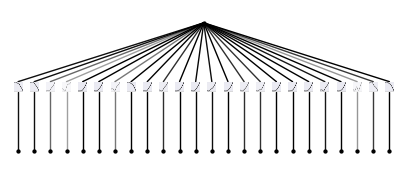

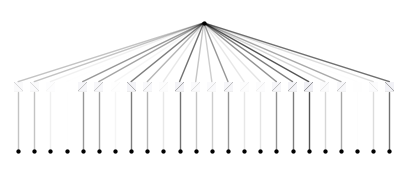

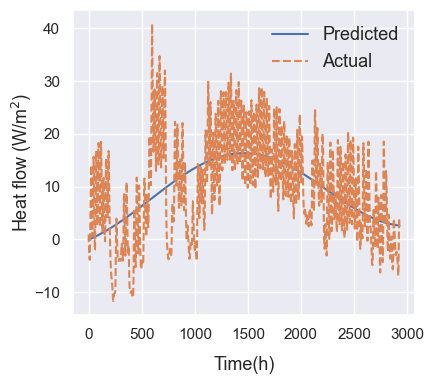

In [6]:
N_grid = 24
# Prepare the data
x_data = np.tile(t, (N_grid, 1)).T
y_data = Heat_gain

# Normalize the data
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0) + 1e-8  # Add small constant to avoid division by zero
x_data_norm = (x_data - x_mean) / x_std

y_mean = np.mean(y_data)
y_std = np.std(y_data) + 1e-8  # Add small constant to avoid division by zero
y_data_norm = (y_data - y_mean) / y_std

# Convert to tensors
x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_data_norm, dtype=torch.float32).unsqueeze(1)

print(x_tensor.shape)
print(y_tensor.shape)

# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary as expected by KAN
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Initialize KAN with adjusted parameters
model = KAN(width=[N_grid, 1], grid=5, k=5, seed=0)  # Input layer now has 1 neuron

# Plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100)

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

# Define early stopping training function with performance evaluation
def train_kan_with_early_stopping(model, dataset, patience=10, steps=10000):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for step in range(steps):
        optimizer.zero_grad()
        outputs = model(dataset['train_input'])
        loss = nn.MSELoss()(outputs, dataset['train_label'])
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = nn.MSELoss()(val_outputs, dataset['test_label']).item()
        print(f'Step [{step+1}/{steps}], Val Loss: {val_loss:.4f}')    

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Calculate metrics after training
    with torch.no_grad():
        test_predictions = model(dataset['test_input']).flatten()
        mae, mse, r2 = calculate_metrics(test_predictions, dataset['test_label'], y_std, y_mean)
        print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')


# Train the model with early stopping and learning rate scheduling
train_kan_with_early_stopping(model, dataset, steps=100, patience=10)


#Plot trained KAN
model.plot()
#Automatically set activation functions to be symbolic
# lib = ['x', 'sin', 'exp']
lib = ['sin']
model.auto_symbolic(lib=lib)


#Continue training to almost machine precision
train_kan_with_early_stopping(model, dataset, steps=20000, patience=10)

#Obtain the symbolic formula in terms of normalized data
symbolic_formula_normalized = model.symbolic_formula()[0][0]

# Reverse normalization for symbolic formula using sympy
x_sym = symbols('x')
y_sym = symbols('y')
normalized_formula = sympify(symbolic_formula_normalized)

# Replace normalized variables with original scale variables
original_formula = normalized_formula.subs(x_sym, (x_sym - x_mean[0]) / x_std[0])
original_formula = original_formula * y_std + y_mean

print("Discovered Symbolic Formula (Original):")
print(original_formula)

# Plot results
Predicted_heat_gain = model(x_tensor).detach().numpy().flatten() * y_std + y_mean

sns.set_context("notebook")
sns.set_palette("deep")
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(4.5, 4), dpi=100)
ax.plot(Predicted_heat_gain, label='Predicted')
ax.plot(Heat_gain, label='Actual', linestyle='--')
ax.set_xlabel('Time(h)',fontsize=13,labelpad=10)
ax.set_ylabel(r'Heat flow (W/m$^2$)',fontsize=13,labelpad=0.000001)
ax.tick_params(direction='out', length=6, width=200)
ax.legend(fontsize=13,frameon=False)
plt.tight_layout()
plt.savefig('PredictedTemperatureDistribution.png', dpi=300)
plt.show()

data = {
    'predicted': Predicted_heat_gain,
    'actual': Heat_gain
}
df = pd.DataFrame(data)
df.to_csv('heat_gain_predictions.csv', index=False)